# MACHINE TRANSLATION WITH TRANSFORMERS FROM SCRATCH

This project implements a Transformer-based neural machine translation system built entirely from scratch, trained on the Multi30k (English→German) dataset. It demonstrates how self-attention, encoder–decoder architecture, and positional encoding enable effective sequence-to-sequence translation without relying on recurrent networks.


## 0. Import Libraries


In [1]:
# !pip install sacrebleu spacy

In [2]:
import math
import random

import spacy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from spacy.cli import download
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import sacrebleu
from tqdm.auto import tqdm
from jiwer import cer as jiwer_cer
from jiwer import wer as jiwer_wer

import ipywidgets as widgets
from IPython.display import display

import warnings

warnings.filterwarnings("ignore")

In [3]:
# download("en_core_web_sm")
# download("de_core_news_sm")

## 1. CONFIGURATION


In [4]:
# Configuration
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
MODEL_DIM = 256  # 256, 1024
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
ff_dim = 1024  # 512, 4096
DROPOUT = 0.3
MAX_LEN = 50
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Using device: {device}")


🖥️  Using device: cpu


## 2. DATA LOADING - Multi30k Dataset


In [5]:
def load_tokenizers():
    """Load spacy tokenizers for English and German"""
    try:
        spacy_en = spacy.load("en_core_web_sm")
        spacy_de = spacy.load("de_core_news_sm")
    except:
        print("\nSpacy models not found. Installing...")
        print("Run these commands:")
        print("  python -m spacy download en_core_web_sm")
        print("  python -m spacy download de_core_news_sm")
        raise

    def tokenize_en(text):
        return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

    def tokenize_de(text):
        return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

    return tokenize_en, tokenize_de


def build_vocab(tokenizer, data_iter, min_freq=2):
    """Build vocabulary from data iterator using Counter (compatible across torchtext versions)."""
    counter = Counter()
    for text in data_iter:
        counter.update(tokenizer(text))

    # Sort tokens by frequency (desc) then alphabetically for determinism
    tokens = [tok for tok, freq in counter.items() if freq >= min_freq]
    tokens.sort(key=lambda t: (-counter[t], t))

    # Specials
    specials = ["<pad>", "<sos>", "<eos>", "<unk>"]

    # Build stoi
    stoi = {tok: idx for idx, tok in enumerate(specials)}
    for tok in tokens:
        if tok not in stoi:
            stoi[tok] = len(stoi)

    # itos
    itos = [None] * len(stoi)
    for tok, idx in stoi.items():
        itos[idx] = tok

    class SimpleVocab:
        def __init__(self, stoi, itos):
            self._stoi = stoi
            self._itos = itos
            self._default_index = self._stoi.get("<unk>", 0)

        def __len__(self):
            return len(self._itos)

        def __getitem__(self, token):
            return self._stoi.get(token, self._default_index)

        def get_itos(self):
            return self._itos

        def set_default_index(self, idx):
            self._default_index = idx

    vocab = SimpleVocab(stoi, itos)
    vocab.set_default_index(vocab._stoi.get("<unk>", 0))
    return vocab


def extract_pairs_from_split(dataset_split):
    pairs = []
    for ex in dataset_split:
        # Standard HF format
        if "translation" in ex and isinstance(ex["translation"], dict):
            en = ex["translation"].get("en", "")
            de = ex["translation"].get("de", "")
        # Some datasets have flat structure
        elif "en" in ex and "de" in ex:
            en = ex["en"]
            de = ex["de"]
        else:
            # Fallbacks
            en = ex.get("en", "")
            de = ex.get("de", "")
        if en and de:
            # Append pair in (source, target) order -> (en, de)
            pairs.append((en, de))
    return pairs


def load_multi30k_data(url="bentrevett/multi30k"):
    """
    Load Multi30k dataset (English-German translations) via Hugging Face.

    Multi30k contains ~30k image captions translated from English to German.
    """
    print("LOADING MULTI30K DATASET (EN → DE)\n")

    # Load tokenizers
    tokenize_en, tokenize_de = load_tokenizers()

    # Load dataset splits from Hugging Face
    ds = load_dataset(url)

    # Handle validation split naming differences
    valid_key = (
        "validation" if "validation" in ds else ("valid" if "valid" in ds else None)
    )
    train_data = extract_pairs_from_split(ds["train"]) if "train" in ds else []
    valid_data = extract_pairs_from_split(ds[valid_key]) if valid_key else []
    test_data = extract_pairs_from_split(ds["test"]) if "test" in ds else []

    print(f"✓ Train: {len(train_data)} pairs")
    print(f"✓ Valid: {len(valid_data)} pairs")
    print(f"✓ Test:  {len(test_data)} pairs")

    # Build vocabularies
    print("\n📚 Building vocabularies...")
    src_vocab = build_vocab(
        tokenize_en, [en for en, de in train_data + valid_data + test_data]
    )
    tgt_vocab = build_vocab(
        tokenize_de, [de for en, de in train_data + valid_data + test_data]
    )

    print(f"✓ English vocab size: {len(src_vocab)}")
    print(f"✓ German vocab size:  {len(tgt_vocab)}")

    return (
        train_data,
        valid_data,
        test_data,
        src_vocab,
        tgt_vocab,
        tokenize_en,
        tokenize_de,
    )

In [6]:
# Load data
(
    train_data,
    valid_data,
    test_data,
    src_vocab,
    tgt_vocab,
    tokenize_en,
    tokenize_de,
) = load_multi30k_data()

pad_idx = src_vocab["<pad>"]

LOADING MULTI30K DATASET (EN → DE)

✓ Train: 29000 pairs
✓ Valid: 1014 pairs
✓ Test:  1000 pairs

📚 Building vocabularies...
✓ English vocab size: 6082
✓ German vocab size:  8148


## 3. DATASET AND DATALOADER


In [7]:
class TranslationDataset(Dataset):
    """PyTorch Dataset for translation"""

    def __init__(
        self, data, src_vocab, tgt_vocab, tokenize_src, tokenize_tgt, max_len=50
    ):
        self.data = data
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.tokenize_src = tokenize_src
        self.tokenize_tgt = tokenize_tgt
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text, tgt_text = self.data[idx]

        # Tokenize
        src_tokens = self.tokenize_src(src_text)[: self.max_len - 2]
        tgt_tokens = self.tokenize_tgt(tgt_text)[: self.max_len - 2]

        # Convert to indices with <sos> and <eos>
        src_indices = (
            [self.src_vocab["<sos>"]]
            + [self.src_vocab[token] for token in src_tokens]
            + [self.src_vocab["<eos>"]]
        )

        tgt_indices = (
            [self.tgt_vocab["<sos>"]]
            + [self.tgt_vocab[token] for token in tgt_tokens]
            + [self.tgt_vocab["<eos>"]]
        )

        return torch.LongTensor(src_indices), torch.LongTensor(tgt_indices)


def collate_fn(batch):
    """Collate function to pad sequences in batch"""
    src_batch, tgt_batch = zip(*batch)

    # Pad sequences
    src_batch = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=0)

    return src_batch, tgt_batch

In [8]:
# Create datasets
train_dataset = TranslationDataset(
    train_data, src_vocab, tgt_vocab, tokenize_en, tokenize_de, MAX_LEN
)
valid_dataset = TranslationDataset(
    valid_data, src_vocab, tgt_vocab, tokenize_en, tokenize_de, MAX_LEN
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

## 4. POSITIONAL ENCODING


In [9]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to embeddings using sine/cosine functions.
    PE(pos, 2i) = sin(pos / 10000^(2i/model_dim))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/model_dim))

    Why: Transformers have no recurrence, so we need to inject position info.
    """

    def __init__(self, model_dim, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, model_dim, 2).float() * -(math.log(10000.0) / model_dim)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, model_dim)

        self.register_buffer("pe", pe)

    def forward(self, x):
        """x: (batch_size, seq_len, model_dim)"""
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

## 5. MULTI-HEAD ATTENTION


In [10]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism - the heart of the Transformer.

    CORE CONCEPT:
    - Query (Q): "What am I looking for?" - the current position asking questions
    - Key (K): "What do I contain?" - all positions advertising their content
    - Value (V): "What information do I have?" - actual content to retrieve

    Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V

    The dot product QK^T computes similarity between query and all keys.
    Softmax converts to probability distribution.
    We then take weighted sum of values.

    MULTI-HEAD: Run this process in parallel with different learned projections,
    allowing the model to attend to different aspects simultaneously.
    """

    def __init__(self, model_dim, num_heads, dropout=0.1):
        super().__init__()
        assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"

        self.model_dim = model_dim
        self.num_heads = num_heads
        self.d_k = model_dim // num_heads  # Dimension per head

        # Linear projections for Q, K, V (one for all heads, split later)
        self.W_q = nn.Linear(model_dim, model_dim)
        self.W_k = nn.Linear(model_dim, model_dim)
        self.W_v = nn.Linear(model_dim, model_dim)

        # Output projection
        self.W_o = nn.Linear(model_dim, model_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)  # Scale factor to prevent small gradients

    def split_heads(self, x, batch_size):
        """Split into multiple heads: (batch, seq_len, model_dim) -> (batch, num_heads, seq_len, d_k)"""
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(1, 2)

    def forward(self, query, key, value, mask=None):
        """
        Args:
            query: (batch_size, seq_len_q, model_dim)
            key: (batch_size, seq_len_k, model_dim)
            value: (batch_size, seq_len_v, model_dim)
            mask: (batch_size, 1, 1, seq_len_k) or (batch_size, 1, seq_len_q, seq_len_k)

        Returns:
            output: (batch_size, seq_len_q, model_dim)
            attention_weights: (batch_size, num_heads, seq_len_q, seq_len_k)
        """
        batch_size = query.size(0)

        # 1. Linear projections in batch
        Q = self.W_q(query)  # (batch, seq_len_q, model_dim)
        K = self.W_k(key)  # (batch, seq_len_k, model_dim)
        V = self.W_v(value)  # (batch, seq_len_v, model_dim)

        # 2. Split into multiple heads
        Q = self.split_heads(Q, batch_size)  # (batch, num_heads, seq_len_q, d_k)
        K = self.split_heads(K, batch_size)  # (batch, num_heads, seq_len_k, d_k)
        V = self.split_heads(V, batch_size)  # (batch, num_heads, seq_len_v, d_k)

        # 3. Scaled dot-product attention
        # Compute attention scores: QK^T / sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        # Shape: (batch, num_heads, seq_len_q, seq_len_k)

        # 4. Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # 5. Apply softmax to get attention weights
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # 6. Apply attention weights to values
        context = torch.matmul(attn_weights, V)  # (batch, num_heads, seq_len_q, d_k)

        # 7. Concatenate heads
        context = context.transpose(
            1, 2
        ).contiguous()  # (batch, seq_len_q, num_heads, d_k)
        context = context.view(
            batch_size, -1, self.model_dim
        )  # (batch, seq_len_q, model_dim)

        # 8. Final linear projection
        output = self.W_o(context)

        return output, attn_weights

## 6. FEED-FORWARD NETWORK


In [11]:
class FeedForward(nn.Module):
    """
    Position-wise feed-forward network: FFN(x) = max(0, xW1 + b1)W2 + b2

    Applied independently to each position. Same across positions but
    different parameters from layer to layer.
    """

    def __init__(self, model_dim, ff_dim, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(model_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        # First linear transformation -> Apply ReLU activation (non-linearity) -> Apply dropout (Regularization) -> Second linear transformation -> Return result
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

## 7. ENCODER


In [12]:
class EncoderLayer(nn.Module):
    """
    Single encoder layer: Self-Attention + Feed-Forward

    Self-Attention: Each position attends to all positions in the input.
    This allows the model to gather context from the entire sequence.
    """

    def __init__(self, model_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(model_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(model_dim)
        self.feed_forward = FeedForward(model_dim, ff_dim, dropout)
        self.norm2 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Self-attention with residual connection
        attn_output, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x


class Encoder(nn.Module):
    """
    Transformer Encoder: Stack of N encoder layers.
    """

    def __init__(self, model_dim, num_heads, ff_dim, num_encoder_layers, dropout=0.1):
        super().__init__()
        # Encoder stack
        self.encoder_layers = nn.ModuleList(
            [
                EncoderLayer(model_dim, num_heads, ff_dim, dropout)
                for _ in range(num_encoder_layers)
            ]
        )

    def forward(self, src, src_mask):
        """Pass the input through each encoder layer in turn."""
        for layer in self.encoder_layers:
            src = layer(src, src_mask)
        return src

## 8. DECODER


In [ ]:
class DecoderLayer(nn.Module):
    """
    Single decoder layer: Masked Self-Attention + Cross-Attention + Feed-Forward

    1. Masked Self-Attention: Attend to previous positions only (causal)
    2. Cross-Attention: Attend to encoder output (Q from decoder, K,V from encoder)
    3. Feed-Forward: Position-wise transformation
    """

    def __init__(self, model_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(model_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(model_dim)
        self.cross_attn = MultiHeadAttention(model_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(model_dim)
        self.feed_forward = FeedForward(model_dim, ff_dim, dropout)
        self.norm3 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)
        self.last_cross_attn_weights = None

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Masked self-attention (look at previous tokens only)
        attn_output, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Cross-attention with encoder output
        # Q: decoder, K,V: encoder - "What information from source is relevant?"
        attn_output, attn_weights = self.cross_attn(x, enc_output, enc_output, src_mask)
        self.last_cross_attn_weights = attn_weights
        x = self.norm2(x + self.dropout(attn_output))

        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x


class Decoder(nn.Module):
    """
    Transformer Decoder: Stack of N decoder layers.
    """

    def __init__(self, model_dim, num_heads, ff_dim, num_decoder_layers, dropout=0.1):
        super().__init__()
        # Decoder stack
        self.decoder_layers = nn.ModuleList(
            [
                DecoderLayer(model_dim, num_heads, ff_dim, dropout)
                for _ in range(num_decoder_layers)
            ]
        )

    def forward(self, tgt, enc_output, src_mask, tgt_mask):
        """Pass the target and encoder output through each decoder layer in turn."""
        for layer in self.decoder_layers:
            tgt = layer(tgt, enc_output, src_mask, tgt_mask)
        return tgt

## 9. TRANSFORMER


In [14]:
class Transformer(nn.Module):
    """
    Complete Transformer model for sequence-to-sequence translation.

    Architecture:
    Source -> Embedding -> Encoder Stack -> Encoder Output
                                               ↓
    Target -> Embedding -> Decoder Stack -> Output Projection -> Probabilities

    KEY ADVANTAGE OVER RNN:
    - RNN: Sequential processing, can't parallelize, long-term dependencies difficulty
    - Transformer: All positions processed in parallel, direct connections via attention
    """

    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        model_dim=512,
        num_heads=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
        ff_dim=2048,
        max_seq_len=100,
        dropout=0.1,
        pad_idx=0,
    ):
        super().__init__()

        self.model_dim = model_dim
        self.pad_idx = pad_idx

        # Embeddings
        self.src_embedding = nn.Embedding(
            src_vocab_size, model_dim, padding_idx=pad_idx
        )
        self.tgt_embedding = nn.Embedding(
            tgt_vocab_size, model_dim, padding_idx=pad_idx
        )

        # Positional encoding
        self.pos_encoding = PositionalEncoding(model_dim, max_seq_len, dropout)

        # Encoder
        self.encoder = Encoder(
            model_dim=model_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_encoder_layers=num_encoder_layers,
            dropout=dropout,
        )

        # Decoder
        self.decoder = Decoder(
            model_dim=model_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout,
        )

        # Output projection
        self.fc_out = nn.Linear(model_dim, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        """Xavier initialization for better gradient flow"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def make_src_mask(self, src):
        """
        Create mask for source sequence to hide padding tokens.
        Shape: (batch, 1, 1, src_len)
        """
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_tgt_mask(self, tgt):
        """
        Create mask for target sequence:
        1. Hide padding tokens
        2. Hide future tokens (causal/autoregressive mask)

        This prevents the decoder from "cheating" by looking at future tokens.
        """
        tgt_len = tgt.size(1)
        tgt_mask = (
            (tgt != self.pad_idx).unsqueeze(1).unsqueeze(2)
        )  # (batch, 1, 1, tgt_len)

        # Create causal mask (lower triangular matrix)
        nopeak_mask = torch.tril(torch.ones(tgt_len, tgt_len)).bool()
        nopeak_mask = nopeak_mask.unsqueeze(0).unsqueeze(0)  # (1, 1, tgt_len, tgt_len)

        tgt_mask = tgt_mask & nopeak_mask.to(tgt.device)
        return tgt_mask

    def encode(self, src):
        """Encode source sequence"""
        src_mask = self.make_src_mask(src)
        x = self.src_embedding(src) * math.sqrt(self.model_dim)  # Scale embeddings
        x = self.pos_encoding(x)

        return self.encoder(x, src_mask), src_mask

    def decode(self, tgt, enc_output, src_mask):
        """Decode target sequence"""
        tgt_mask = self.make_tgt_mask(tgt)
        x = self.tgt_embedding(tgt) * math.sqrt(self.model_dim)
        x = self.pos_encoding(x)

        return self.decoder(x, enc_output, src_mask, tgt_mask)

    def forward(self, src, tgt):
        """
        Forward pass for training.

        Args:
            src: (batch_size, src_len) - source tokens
            tgt: (batch_size, tgt_len) - target tokens

        Returns:
            output: (batch_size, tgt_len, tgt_vocab_size) - logits
        """

        enc_output, src_mask = self.encode(src)
        dec_output = self.decode(tgt, enc_output, src_mask)

        output = self.fc_out(dec_output)
        return output

In [15]:
print("TRANSFORMER TRANSLATION: English → German (Multi30k)")

# Create model
model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    model_dim=MODEL_DIM,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    ff_dim=ff_dim,
    max_seq_len=MAX_LEN,
    dropout=DROPOUT,
    pad_idx=pad_idx,
).to(device)

print(f"\n🏗️  Model Architecture:")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  model_dim: {MODEL_DIM}, num_heads: {NUM_HEADS}")
print(f"  Encoder layers: {NUM_ENCODER_LAYERS}, Decoder layers: {NUM_DECODER_LAYERS}")

# Loss, optimizer, and scheduler
print("\nConfiguring Loss, Optimizer, and Scheduler...")
criterion = nn.CrossEntropyLoss(
    reduction="mean", ignore_index=pad_idx, label_smoothing=0.1
)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

TRANSFORMER TRANSLATION: English → German (Multi30k)

🏗️  Model Architecture:
  Parameters: 13,109,716
  model_dim: 256, num_heads: 8
  Encoder layers: 4, Decoder layers: 4

Configuring Loss, Optimizer, and Scheduler...


## 10. GREEDY DECODING (Basic)


In [16]:
def greedy_decode(model, src, src_vocab, tgt_vocab, device, max_len=50):
    """Generate translation using greedy decoding"""
    model.eval()

    with torch.no_grad():
        # Encode source
        src_tensor = src.unsqueeze(0).to(device)
        enc_output, src_mask = model.encode(src_tensor)

        # Start with <sos> token
        sos_idx = tgt_vocab["<sos>"]
        eos_idx = tgt_vocab["<eos>"]
        tgt_indices = [sos_idx]

        for _ in range(max_len):
            tgt_tensor = torch.LongTensor([tgt_indices]).to(device)

            # Decode
            dec_output = model.decode(tgt_tensor, enc_output, src_mask)
            output = model.fc_out(dec_output)

            # Get the last token prediction
            next_token = output[0, -1, :].argmax().item()
            tgt_indices.append(next_token)

            # Stop if <eos> is generated
            if next_token == eos_idx:
                break

        return tgt_indices


def translate_sentence(
    sentence, model, src_vocab, tgt_vocab, tokenize_src, device, max_len=50
):
    """Translate a single sentence"""
    model.eval()

    # Tokenize and convert to indices
    tokens = tokenize_src(sentence)
    indices = (
        [src_vocab["<sos>"]]
        + [src_vocab[token] for token in tokens]
        + [src_vocab["<eos>"]]
    )
    src_tensor = torch.LongTensor(indices)

    # Decode
    tgt_indices = greedy_decode(
        model, src_tensor, src_vocab, tgt_vocab, device, max_len
    )

    # Convert indices back to words
    tgt_tokens = [tgt_vocab.get_itos()[idx] for idx in tgt_indices]

    # Remove special tokens
    translation = " ".join(
        [t for t in tgt_tokens if t not in ["<sos>", "<eos>", "<pad>"]]
    )

    return translation

## 11. BEAM SEARCH DECODING (Advanced)


In [17]:
def beam_search_decode(
    model, src, src_vocab, tgt_vocab, device, beam_width=3, max_len=50
):
    """
    Generate translation using beam search.

    Beam Search: Maintain top-k most probable sequences at each step.
    Better than greedy but more computationally expensive.

    beam_width: Number of hypotheses to maintain (k)
    """
    model.eval()

    with torch.no_grad():
        # Encode source
        src_tensor = src.unsqueeze(0).to(device)
        enc_output, src_mask = model.encode(src_tensor)

        # Initialize beam with <sos> token
        # Each hypothesis: (sequence, score)
        beams = [([tgt_vocab["<sos>"]], 0.0)]

        for _ in range(max_len):
            new_beams = []

            for seq, score in beams:
                # If sequence ends with <eos>, keep it
                if seq[-1] == tgt_vocab["<eos>"]:
                    new_beams.append((seq, score))
                    continue

                # Generate next token probabilities
                tgt_tensor = torch.LongTensor([seq]).to(device)
                dec_output = model.decode(tgt_tensor, enc_output, src_mask)
                output = model.fc_out(dec_output)

                # Get log probabilities for last token
                log_probs = torch.log_softmax(output[0, -1, :], dim=-1)

                # Get top-k tokens
                topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)

                # Extend sequences
                for log_prob, idx in zip(topk_log_probs, topk_indices):
                    new_seq = seq + [idx.item()]
                    new_score = score + log_prob.item()
                    new_beams.append((new_seq, new_score))

            # Keep top beam_width sequences
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

            # Stop if all beams end with <eos>
            if all(seq[-1] == tgt_vocab["<eos>"] for seq, _ in beams):
                break

        # Return best sequence
        best_seq, _ = beams[0]
        return best_seq

## 12. ATTENTION VISUALIZATION & TEXT METRICS


In [18]:
def visualize_attention(
    model,
    sentence,
    src_vocab,
    tgt_vocab,
    tokenize_src,
    device,
    max_len=50,
):
    """Generate a translation and visualize cross-attention weights."""
    model.eval()

    # ----------------------------------------------------------
    # 1. Tokenize & convert tokens to indices using SimpleVocab
    # ----------------------------------------------------------
    src_tokens = tokenize_src(sentence)

    src_indices = (
        [src_vocab["<sos>"]]
        + [src_vocab[t] for t in src_tokens]  # uses __getitem__ safely
        + [src_vocab["<eos>"]]
    )

    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)

    # --- 2. Encode ---
    enc_output, src_mask = model.encode(src_tensor)

    # --- 3. Decoding loop ---
    generated = [tgt_vocab["<sos>"]]
    attention_steps = []

    for _ in range(max_len):
        tgt_tensor = torch.LongTensor([generated]).to(device)
        tgt_mask = model.make_tgt_mask(tgt_tensor)

        # Embedding + Positional encoding
        x = model.tgt_embedding(tgt_tensor) * math.sqrt(model.model_dim)
        x = model.pos_encoding(x)

        # Forward through decoder layers
        for layer in model.decoder.decoder_layers:
            x = layer(x, enc_output, src_mask, tgt_mask)

        logits = model.fc_out(x)
        next_token = logits[0, -1].argmax().item()

        # Get last-layer cross-attention
        last_layer = model.decoder.decoder_layers[-1]
        attn = last_layer.last_cross_attn_weights  # (B, H, tgt_len, src_len)

        if attn is not None:
            attn_last = attn[0, :, -1, :].detach().cpu().numpy()
            attention_steps.append(attn_last)

        generated.append(next_token)

        if next_token == tgt_vocab["<eos>"]:
            break

    if not attention_steps:
        print("⚠️ No attention weights captured. Cannot visualize.")
        return

    # --- 4. Aggregate heads ---
    attention_matrix = np.stack(attention_steps, axis=0).mean(axis=1)

    # ----------------------------------------------------------
    # 5. Reconstruct tokens using SimpleVocab.get_itos()
    # ----------------------------------------------------------
    src_itos = src_vocab.get_itos()
    tgt_itos = tgt_vocab.get_itos()

    src_tokens_vis = [
        src_itos[idx] if idx < len(src_itos) else "<unk>" for idx in src_indices
    ]

    tgt_tokens = [
        tgt_itos[idx] if idx < len(tgt_itos) else "<unk>"
        for idx in generated[1 : 1 + len(attention_steps)]
    ]

    # --- 6. Attention heatmap ---
    plt.figure(figsize=(min(12, 0.7 * len(src_tokens_vis)), 0.7 * len(tgt_tokens)))
    plt.imshow(attention_matrix, aspect="auto", cmap="viridis")
    plt.colorbar(label="Attention")

    plt.xticks(range(len(src_tokens_vis)), src_tokens_vis, rotation=45, ha="right")
    plt.yticks(range(len(tgt_tokens)), tgt_tokens)

    plt.xlabel("Source tokens")
    plt.ylabel("Generated tokens")
    plt.title("Cross-Attention (last decoder layer)")
    plt.tight_layout()
    plt.show()

    # --- 7. Print translation (remove specials) ---
    translation = " ".join(
        t for t in tgt_tokens if t not in ("<sos>", "<eos>", "<pad>")
    )

    print(f"\n🗣️ Source: {sentence}")
    print(f"🔁 Translation: {translation}")

## 13. EVALUATION METRICS (Bleu Score)


In [19]:
def compute_text_metrics(predictions, references):
    """Compute BLEU (sacrebleu), WER, CER given lists of strings."""

    results = {}

    bleu = sacrebleu.corpus_bleu(predictions, [references], force=True)
    results["BLEU"] = bleu.score

    wers, cers = [], []
    for ref, pred in zip(references, predictions):
        try:
            wers.append(jiwer_wer(ref, pred))
            cers.append(jiwer_cer(ref, pred))
        except Exception:
            continue
    results["WER"] = float(np.mean(wers))
    results["CER"] = float(np.mean(cers))

    return results


def plot_metric_bars(results):
    keys = [k for k in ["BLEU", "WER", "CER"] if results.get(k) is not None]
    if not keys:
        print("⚠️  Metrics not available.")
        return

    values = [results[k] for k in keys]
    colors = ["#4caf50" if k == "BLEU" else "#f44336" for k in keys]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(keys, values, color=colors)
    for bar, value in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            value,
            f"{value:.3f}",
            ha="center",
            va="bottom",
        )

    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.grid(axis="y", linestyle=":", alpha=0.5)
    plt.tight_layout()
    plt.show()

## 14. TRAINING


In [20]:
def evaluate(
    model,
    dataloader,
    criterion,
    device,
    src_vocab,
    tgt_vocab,
    max_len=50,
    debug=False,
):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_references = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating")
        for batch_idx, (src_batch, tgt_batch) in enumerate(pbar):
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            # Calculate loss with teacher forcing
            output = model(src_batch, tgt_batch[:, :-1])
            output_dim = output.shape[-1]
            output_flat = output.reshape(-1, output_dim)
            target_flat = tgt_batch[:, 1:].reshape(-1)
            loss = criterion(output_flat, target_flat)
            total_loss += loss.item()

            # Generate translations for BLEU
            for i in range(src_batch.size(0)):
                # PREDICTION - using greedy decode
                src_sentence = src_batch[i]
                pred_indices = greedy_decode(
                    model, src_sentence, src_vocab, tgt_vocab, device, max_len
                )

                # Convert to tokens and clean
                pred_tokens = [tgt_vocab.get_itos()[idx] for idx in pred_indices]
                pred_tokens_clean = [
                    t for t in pred_tokens if t not in ["<sos>", "<eos>", "<pad>"]
                ]
                pred_string = " ".join(pred_tokens_clean)

                # REFERENCE - get ground truth
                tgt_indices = tgt_batch[i].cpu().tolist()
                tgt_tokens = [tgt_vocab.get_itos()[idx] for idx in tgt_indices]
                ref_tokens_clean = [
                    t for t in tgt_tokens if t not in ["<sos>", "<eos>", "<pad>"]
                ]
                ref_string = " ".join(ref_tokens_clean)

                all_predictions.append(pred_string)
                all_references.append(ref_string)

                # Debug first batch only
                if debug and batch_idx == 0 and i < 2:
                    src_indices = src_batch[i].cpu().tolist()
                    src_tokens = [src_vocab.get_itos()[idx] for idx in src_indices]
                    src_clean = [
                        t for t in src_tokens if t not in ["<sos>", "<eos>", "<pad>"]
                    ]
                    print(f"\n[Sample {i+1}]")
                    print(f"  Source:     {' '.join(src_clean)}")
                    print(f"  Prediction: {pred_string}")
                    print(f"  Reference:  {ref_string}")

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / max(1, len(dataloader))

    # Calculate BLEU score
    if all_predictions and all_references:
        bleu_score = sacrebleu.corpus_bleu(
            all_predictions, [all_references], force=True
        ).score
    else:
        bleu_score = 0.0

    return avg_loss, bleu_score, all_predictions, all_references


def train_epoch(model, dataloader, optimizer, criterion, device):
    """Training function for one epoch"""
    model.train()
    total_loss = 0.0
    pbar = tqdm(dataloader, desc="Training")

    for src_batch, tgt_batch in pbar:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        optimizer.zero_grad()

        # Forward pass - teacher forcing
        output = model(src_batch, tgt_batch[:, :-1])
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        target = tgt_batch[:, 1:].reshape(-1)

        loss = criterion(output, target)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        # pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return total_loss / max(1, len(dataloader))


def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    src_vocab,
    tgt_vocab,
    device,
    num_epochs=10,
    max_len=50,
    patience=5,
):
    """Main training loop with early stopping and learning rate scheduling"""
    history = {"train_loss": [], "val_loss": [], "val_ppl": [], "val_bleu": []}
    best_bleu = -1
    epochs_without_improvement = 0

    print(f"TRAINING")

    for epoch in range(1, num_epochs + 1):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

        # Evaluate
        val_loss, val_bleu, predictions, references = evaluate(
            model,
            val_loader,
            criterion,
            device,
            src_vocab,
            tgt_vocab,
            max_len=max_len,
            debug=False,
        )

        # Compute validation perplexity
        val_ppl = math.exp(val_loss)

        # Update history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_ppl"].append(val_ppl)
        history["val_bleu"].append(val_bleu)

        # Print metrics
        print(
            f"Epoch [{epoch}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | PPL: {val_ppl:.2f} | BLEU: {val_bleu:.2f}"
        )

        # Learning rate scheduling
        scheduler.step(val_bleu)

        if val_bleu > best_bleu:
            best_bleu = val_bleu
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"  No improvement ({epochs_without_improvement}/{patience})")

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"\n⚠️  Early stopping triggered after {epoch} epochs")
            break

    print(f"TRAINING COMPLETE!   Best BLEU: {best_bleu:.2f}")

    return history

In [21]:
# TRAINING
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion,
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    device=device,
    num_epochs=EPOCHS,
    max_len=MAX_LEN,
)

TRAINING


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 5.8339 | Val Loss: 5.2277 | PPL: 186.36 | BLEU: 3.92


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/10] Train Loss: 4.9405 | Val Loss: 4.7528 | PPL: 115.91 | BLEU: 6.75


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/10] Train Loss: 4.6139 | Val Loss: 4.4897 | PPL: 89.10 | BLEU: 6.83


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/10] Train Loss: 4.4151 | Val Loss: 4.3192 | PPL: 75.13 | BLEU: 8.47


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/10] Train Loss: 4.2622 | Val Loss: 4.1944 | PPL: 66.31 | BLEU: 9.50


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/10] Train Loss: 4.1331 | Val Loss: 4.0894 | PPL: 59.71 | BLEU: 10.37


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/10] Train Loss: 4.0225 | Val Loss: 3.9765 | PPL: 53.33 | BLEU: 10.46


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/10] Train Loss: 3.9259 | Val Loss: 3.8983 | PPL: 49.32 | BLEU: 11.52


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/10] Train Loss: 3.8419 | Val Loss: 3.8271 | PPL: 45.93 | BLEU: 11.76


Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/10] Train Loss: 3.7663 | Val Loss: 3.7557 | PPL: 42.76 | BLEU: 13.35
TRAINING COMPLETE!   Best BLEU: 13.35


## 15. HISTORY VISUALIZATION


In [22]:
def plot_history(history):
    """
    Plots training and validation loss, along with validation BLEU score over epochs.
    """

    print("\nPlotting training history...")
    epochs = range(1, len(history["train_loss"]) + 1)

    # --- Create figure ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # (1) Plot Loss
    axes[0].plot(
        epochs, history["train_loss"], label="Train Loss", color="blue", marker="o"
    )
    axes[0].plot(epochs, history["val_loss"], label="Val Loss", color="red", marker="o")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training & Validation Loss")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # (2) Plot BLEU
    axes[1].plot(
        epochs, history["val_bleu"], label="Val BLEU", color="green", marker="o"
    )
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("BLEU Score")
    axes[1].set_title("Validation BLEU Score")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.6)

    # (3) Plot PPL
    axes[2].plot(
        epochs, history["val_ppl"], label="Val PPL", color="orange", marker="o"
    )
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("PPL")
    axes[2].set_title("Validation Perplexity")
    axes[2].legend()
    axes[2].grid(True, linestyle="--", alpha=0.6)

    # --- Summary text below plots ---
    plt.suptitle("Training Progress Summary", fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()

    # Save and show
    plt.savefig("training_history.png", dpi=150, bbox_inches="tight")
    plt.show()


Plotting training history...


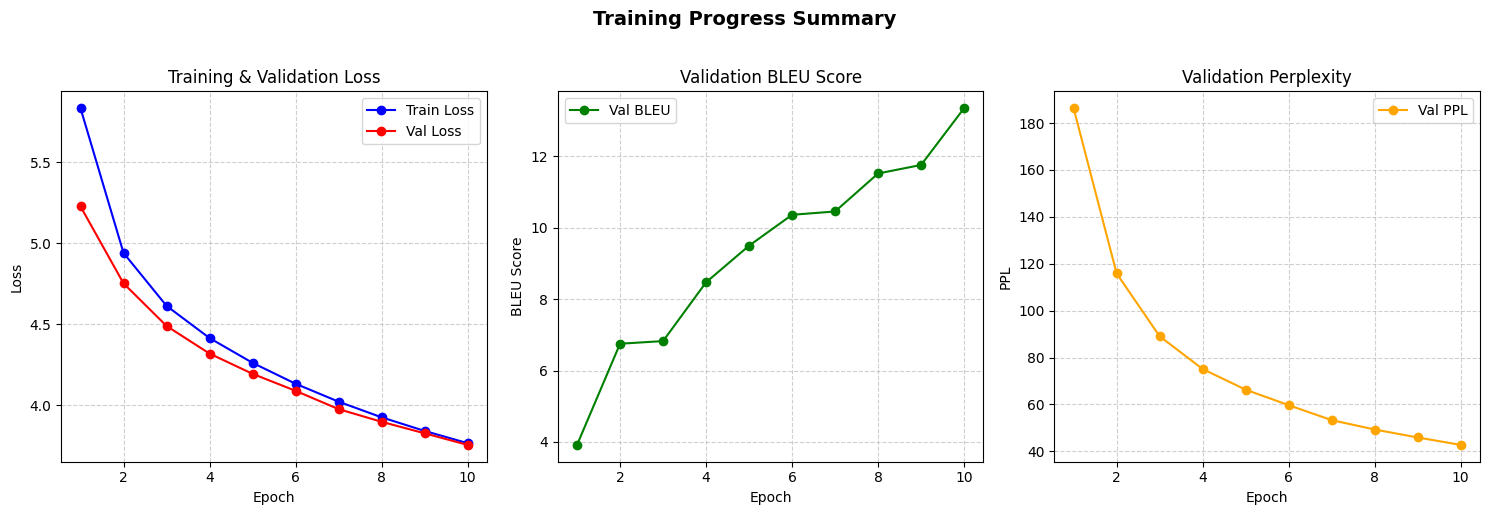

In [23]:
# VISUALIZE TRAINING HISTORY
plot_history(history)

## 16. EVALUATION ON TEST SET


In [24]:
# # LOAD BEST MODEL
# checkpoint = torch.load("best_transformer.pt", map_location=device)
# model.load_state_dict(checkpoint["model_state_dict"])
# print(
#     f"✅ Loaded best model (Epoch {checkpoint['epoch']}, BLEU: {checkpoint['val_bleu']:.4f})"
# )

TEST SET EVALUATION


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]


Test Loss: 3.7206 | Test PPL:   41.29 | BLEU Score: 11.97

Additional Metrics:
WER: 0.715
CER: 0.570


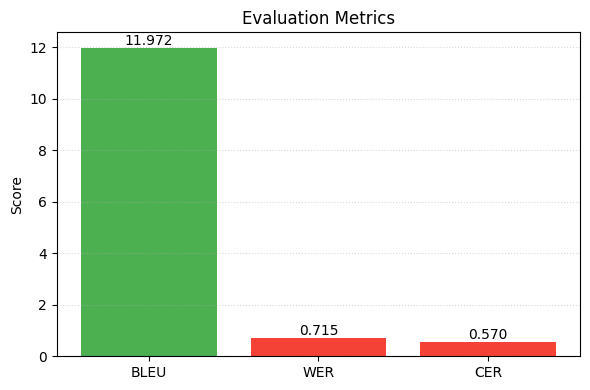

In [25]:
# TEST SET EVALUATION
print("TEST SET EVALUATION")

test_dataset = TranslationDataset(
    test_data, src_vocab, tgt_vocab, tokenize_en, tokenize_de, MAX_LEN
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

test_loss, test_bleu, test_predictions, test_references = evaluate(
    model,
    test_loader,
    criterion,
    device,
    src_vocab,
    tgt_vocab,
    max_len=MAX_LEN,
)

print(
    f"\nTest Loss: {test_loss:.4f} | Test PPL: {math.exp(test_loss):7.2f} | BLEU Score: {test_bleu:.2f}"
)

# Additional metrics & visualization
metrics = compute_text_metrics(test_predictions, test_references)
print("\nAdditional Metrics:")
print(f"WER: {metrics['WER']:.3f}")
print(f"CER: {metrics['CER']:.3f}")

plot_metric_bars(metrics)


VISUALIZING ATTENTION ON A SAMPLE SENTENCE...


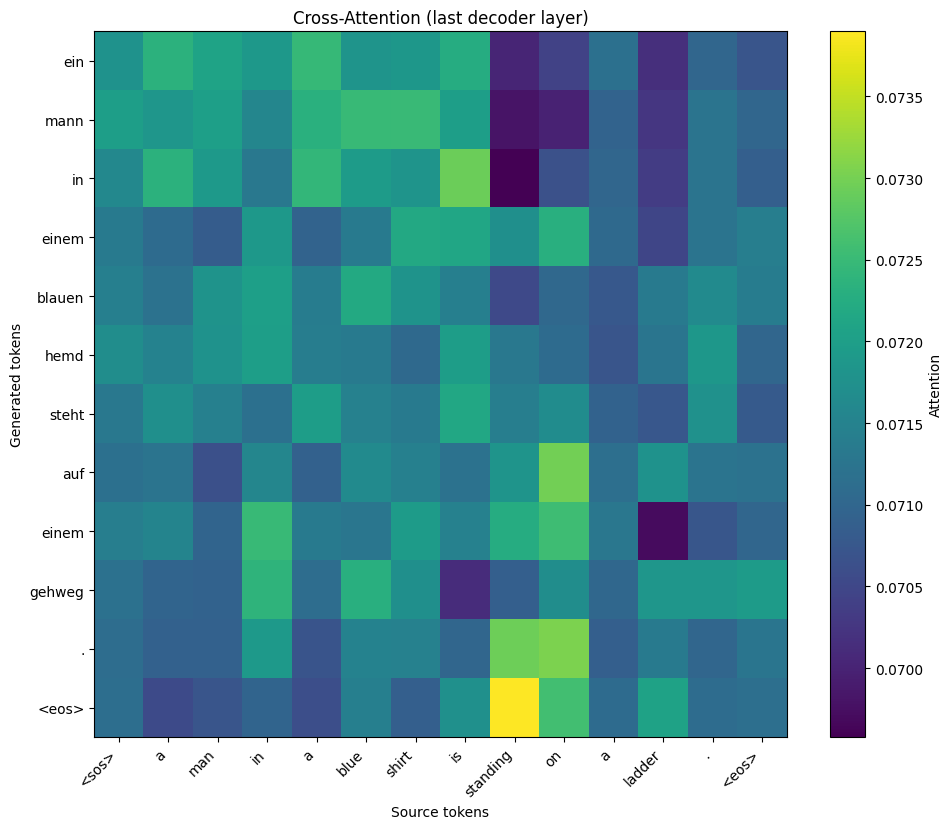


🗣️ Source: A man in a blue shirt is standing on a ladder.
🔁 Translation: ein mann in einem blauen hemd steht auf einem gehweg .


In [26]:
# ATTENTION VISUALIZATION
print("\nVISUALIZING ATTENTION ON A SAMPLE SENTENCE...")
visualize_attention(
    model,
    "A man in a blue shirt is standing on a ladder.",
    src_vocab,
    tgt_vocab,
    tokenize_en,
    device,
)

## 17. INFERENCE


In [27]:
# GREEDY DECODING EXAMPLES
def translation_ui():
    text_input = widgets.Text(
        placeholder="Type an English sentence...",
        description="English:",
        layout=widgets.Layout(width="600px", margin="10px 0 2px 0px"),
    )

    btn = widgets.Button(
        description="Translate",
        button_style="success",
        tooltip="Click to translate",
        layout=widgets.Layout(width="120px", margin="11px 0 2px 10px"),
    )

    # Put both in one horizontal row
    input_row = widgets.HBox([text_input, btn])

    output = widgets.Output()

    def on_click(b):
        output.clear_output()
        en_sentence = text_input.value.strip()
        if en_sentence == "":
            with output:
                print("Please enter a sentence.")
            return

        with output:
            translation = translate_sentence(
                en_sentence, model, src_vocab, tgt_vocab, tokenize_en, device
            )
            print("    ================================")
            print("       English (EN) → German (DE)")
            print("    ================================")
            print(f"    EN: {en_sentence}")
            print(f"    DE: {translation}")

    btn.on_click(on_click)

    display(input_row, output)

In [ ]:
def show_sample_translations(num_samples=3):
    print(f"\nSAMPLE TRANSLATIONS ({num_samples} examples):\n")
    for i in range(num_samples):
        src_sentence, tgt_sentence = random.choice(test_data)
        translation = translate_sentence(
            src_sentence, model, src_vocab, tgt_vocab, tokenize_en, device
        )
        print(f"Sample {i+1}:")
        print(f"EN: {src_sentence}")
        print(f"DE (Predicted): {translation}")
        print(f"DE (Reference): {tgt_sentence}")
        print("-" * 100)

In [35]:
show_sample_translations(num_samples=5)


SAMPLE TRANSLATIONS (5 examples):

Sample 1:
EN: This is a large group of people sitting outside on benches.
DE (Predicted): eine gruppe von menschen sitzt auf einer bühne und steht in der nähe eines gebäudes .
DE (Reference): Das ist eine große Menschengruppe, die im Freien auf Bänken sitzt.
----------------------------------------------------------------------------------------------------
Sample 2:
EN: A boy stands with three girls.
DE (Predicted): ein kleiner junge steht mit zwei kindern .
DE (Reference): Ein Junge steht mit drei Mädchen.
----------------------------------------------------------------------------------------------------
Sample 3:
EN: A hockey game is being played with lots of people watching it.
DE (Predicted): ein paar wird von einem <unk> , um die <unk> zu sehen .
DE (Reference): Ein Hockeyspiel wird vor großem Publikum gespielt.
----------------------------------------------------------------------------------------------------
Sample 4:
EN: Two men selling fr

In [29]:
print("TRANSLATION (GREEDY DECODING)")
translation_ui()

TRANSLATION (GREEDY DECODING)


Output()